# Traffic Light Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Object detection imports

Here are the imports from the object detection module.

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [3]:
ssd_inception_sim_model = 'frozen_models/frozen_sim_inception/frozen_inference_graph.pb'
ssd_inception_real_model = 'frozen_models/frozen_real_inception/frozen_inference_graph.pb'
ssd_inception_bosch_model = 'frozen_models/frozen_bosch_inception/frozen_inference_graph.pb'

PATH_TO_LABELS = 'data/traffic_light_label_map.pbtxt'

NUM_CLASSES = 4

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Red'}, 2: {'id': 2, 'name': 'Yellow'}, 3: {'id': 3, 'name': 'Green'}, 4: {'id': 4, 'name': 'off'}}


In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
from glob import glob

## Detection

## 1. Testing SSD Inception Models

### 1.1 Testing model trained on simulator on simulator images

In [7]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(ssd_inception_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
PATH_TO_TEST_IMAGES_DIR = 'data/test_images_sim'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

data/test_images_sim/*.jpg
Length of test images: 12


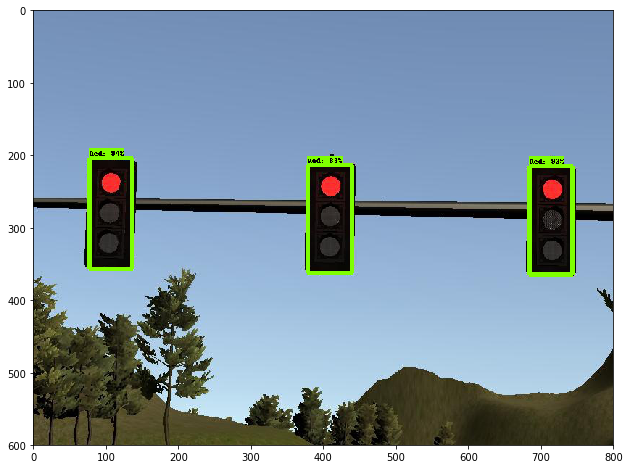

Red 0.943631
Distance (metres) 0.0
Time in milliseconds 4053.6258220672607 

Red 0.927691
Distance (metres) 0.0
Time in milliseconds 4053.6258220672607 

Red 0.839751
Distance (metres) 0.0
Time in milliseconds 4053.6258220672607 



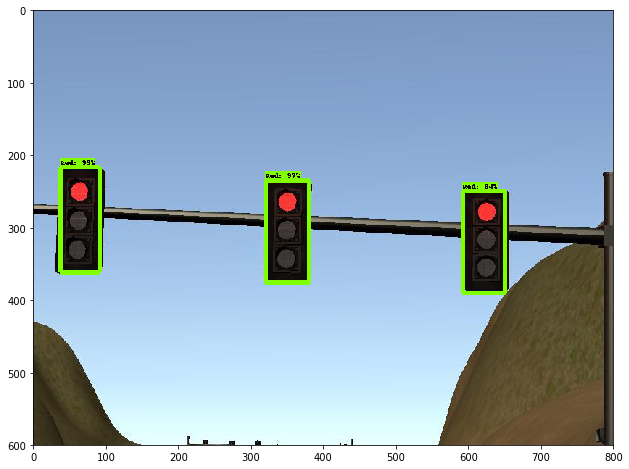

Red 0.976136
Distance (metres) 0.0
Time in milliseconds 30.2889347076416 

Red 0.934107
Distance (metres) 0.0
Time in milliseconds 30.2889347076416 

Red 0.846674
Distance (metres) 0.0
Time in milliseconds 30.2889347076416 



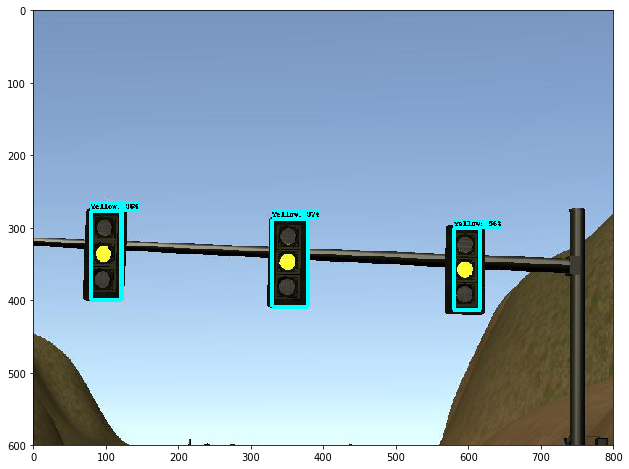

Yellow 0.976513
Distance (metres) 0.0
Time in milliseconds 29.050350189208984 

Yellow 0.965081
Distance (metres) 0.0
Time in milliseconds 29.050350189208984 

Yellow 0.566911
Distance (metres) 0.0
Time in milliseconds 29.050350189208984 



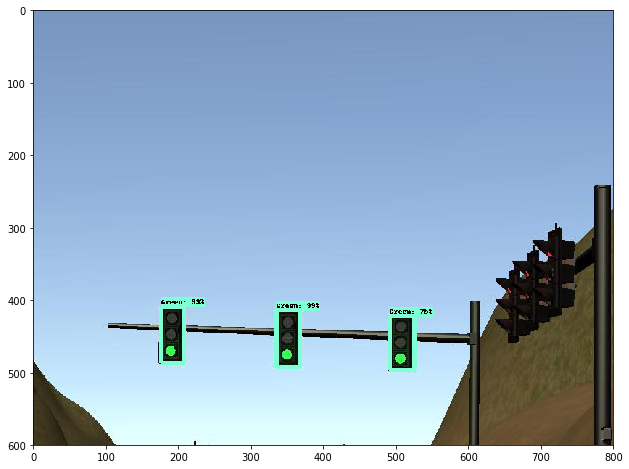

Green 0.993286
Distance (metres) 0.0
Time in milliseconds 29.750585556030273 

Green 0.993268
Distance (metres) 0.0
Time in milliseconds 29.750585556030273 

Green 0.752085
Distance (metres) 0.0
Time in milliseconds 29.750585556030273 



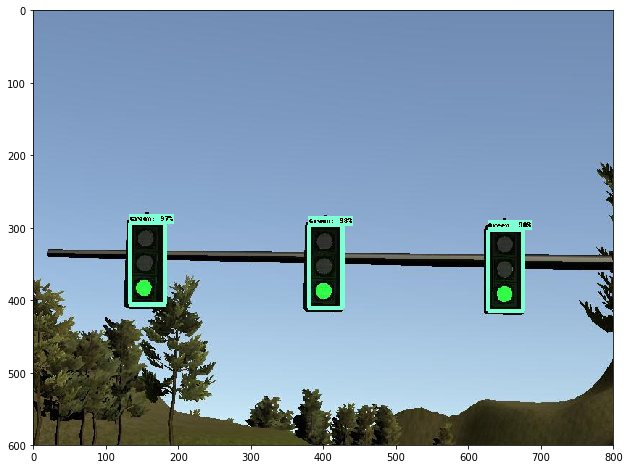

Green 0.980029
Distance (metres) 0.0
Time in milliseconds 29.613971710205078 

Green 0.974491
Distance (metres) 0.0
Time in milliseconds 29.613971710205078 

Green 0.901962
Distance (metres) 0.0
Time in milliseconds 29.613971710205078 



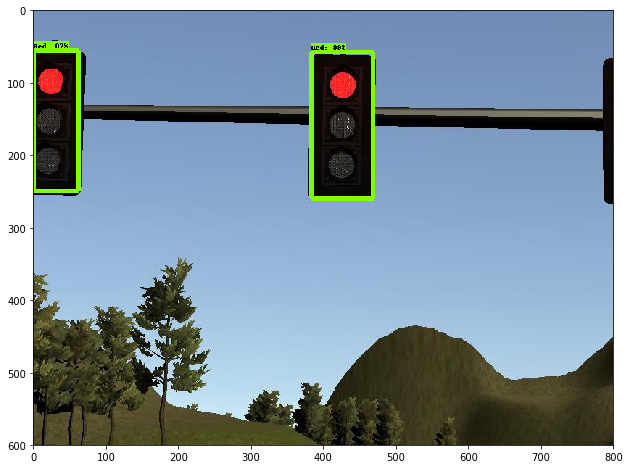

Red 0.998431
Distance (metres) 0.0
Time in milliseconds 30.6398868560791 

Red 0.871996
Distance (metres) 0.0
Time in milliseconds 30.6398868560791 



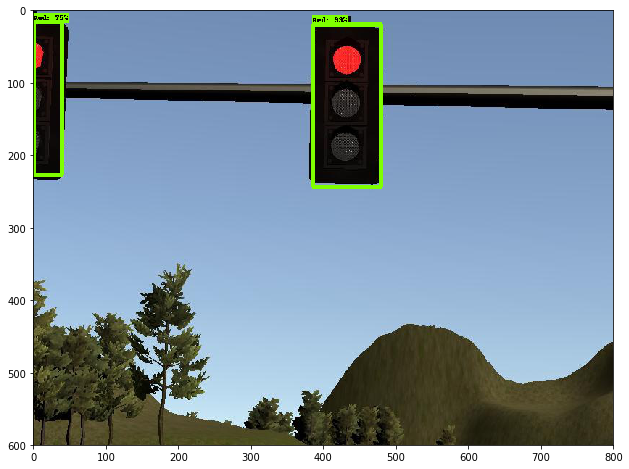

Red 0.999043
Distance (metres) 0.0
Time in milliseconds 30.977725982666016 

Red 0.75212
Distance (metres) 0.0
Time in milliseconds 30.977725982666016 



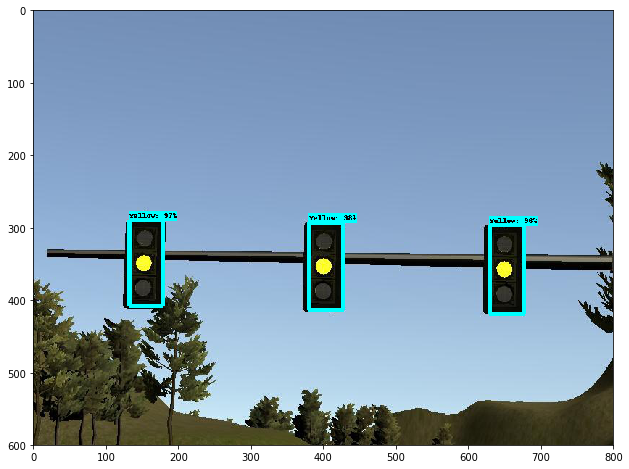

Yellow 0.984761
Distance (metres) 0.0
Time in milliseconds 32.15813636779785 

Yellow 0.978854
Distance (metres) 0.0
Time in milliseconds 32.15813636779785 

Yellow 0.963768
Distance (metres) 0.0
Time in milliseconds 32.15813636779785 



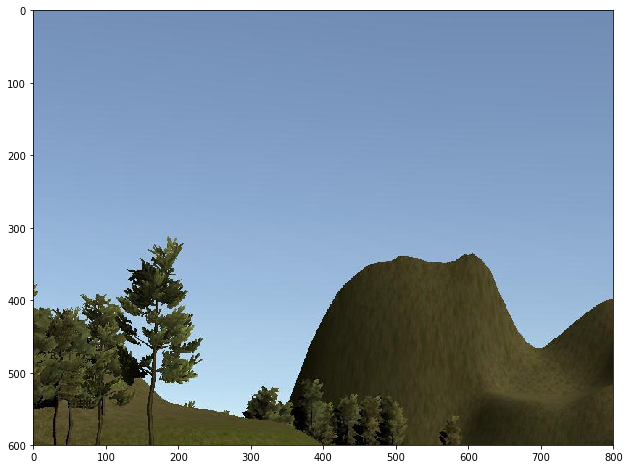

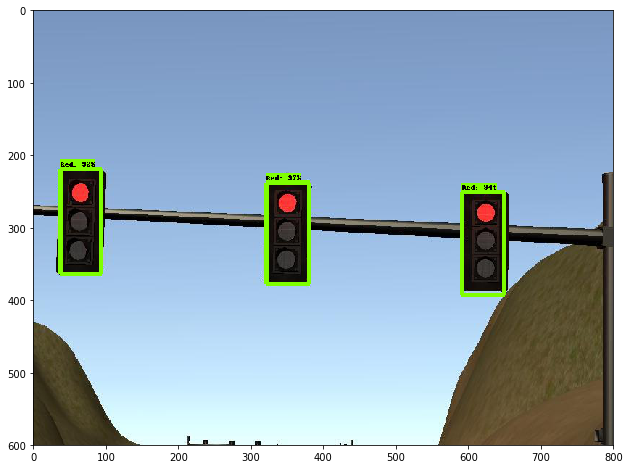

Red 0.979748
Distance (metres) 0.0
Time in milliseconds 27.886390686035156 

Red 0.94034
Distance (metres) 0.0
Time in milliseconds 27.886390686035156 

Red 0.925606
Distance (metres) 0.0
Time in milliseconds 27.886390686035156 



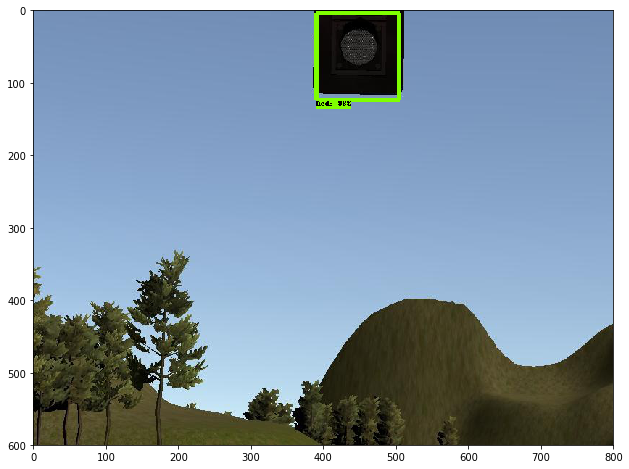

Red 0.98846
Distance (metres) 0.0
Time in milliseconds 33.486127853393555 



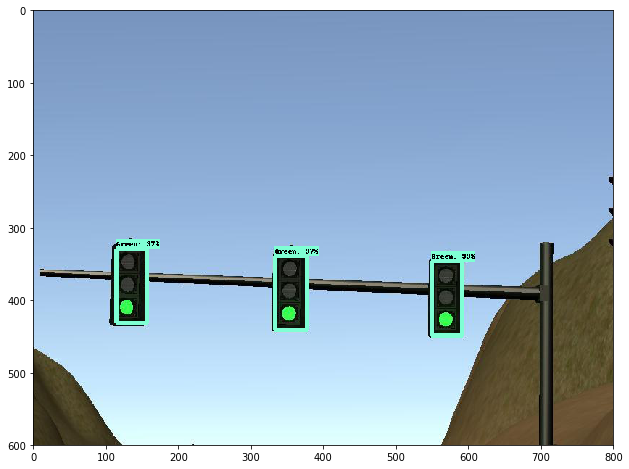

Green 0.997234
Distance (metres) 0.0
Time in milliseconds 31.04400634765625 

Green 0.978053
Distance (metres) 0.0
Time in milliseconds 31.04400634765625 

Green 0.977581
Distance (metres) 0.0
Time in milliseconds 31.04400634765625 



In [9]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 

### 1.2 Testing model trained on real images on Real World images

In [7]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(ssd_inception_real_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [23]:
PATH_TO_TEST_IMAGES_DIR = 'data/test_images_udacity/yellow'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

data/test_images_udacity/yellow/*.jpg
Length of test images: 137


In [24]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        time_start = time.time()
        correct_detection = 0
        total_detection = 0
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            '''
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            print(image_path)
            '''
            min_score_thresh = .50
            

            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    if class_name == 'Yellow':
                        correct_detection = correct_detection + 1
                        
                    total_detection = total_detection + 1
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")
                    
        time_end = time.time()
        print("***********************************\n")
        print("Total number of images:", total_detection)
        print("Correct detections:", correct_detection)
        print("Detection rate:", correct_detection / total_detection)
        print("Total time in milliseconds", (time_end - time_start) * 1000)

Yellow 0.995167
Distance (metres) 9.0
Time in milliseconds 1298.8471984863281 

Yellow 0.996018
Distance (metres) 9.0
Time in milliseconds 30.245065689086914 

Yellow 0.999101
Distance (metres) 7.0
Time in milliseconds 31.456708908081055 

Yellow 0.993957
Distance (metres) 7.0
Time in milliseconds 31.984806060791016 

Yellow 0.994419
Distance (metres) 9.0
Time in milliseconds 30.549287796020508 

Yellow 0.992858
Distance (metres) 8.0
Time in milliseconds 34.316301345825195 

Yellow 0.994867
Distance (metres) 9.0
Time in milliseconds 39.57986831665039 

Yellow 0.994292
Distance (metres) 9.0
Time in milliseconds 34.50131416320801 

Yellow 0.995863
Distance (metres) 10.0
Time in milliseconds 34.03615951538086 

Yellow 0.995801
Distance (metres) 8.0
Time in milliseconds 36.371469497680664 

Yellow 0.997634
Distance (metres) 8.0
Time in milliseconds 38.20371627807617 

Yellow 0.99708
Distance (metres) 10.0
Time in milliseconds 33.09941291809082 

Yellow 0.786108
Distance (metres) 4.0
Time i

Yellow 0.996622
Distance (metres) 8.0
Time in milliseconds 31.75806999206543 

Yellow 0.995964
Distance (metres) 9.0
Time in milliseconds 31.95929527282715 

Yellow 0.997842
Distance (metres) 8.0
Time in milliseconds 30.521392822265625 

Yellow 0.991948
Distance (metres) 8.0
Time in milliseconds 30.16972541809082 

Yellow 0.994592
Distance (metres) 9.0
Time in milliseconds 32.19199180603027 

Yellow 0.995227
Distance (metres) 10.0
Time in milliseconds 33.32352638244629 

Yellow 0.994497
Distance (metres) 9.0
Time in milliseconds 31.307458877563477 

Yellow 0.808285
Distance (metres) 4.0
Time in milliseconds 31.61025047302246 

Yellow 0.994197
Distance (metres) 8.0
Time in milliseconds 34.461021423339844 

Yellow 0.994024
Distance (metres) 9.0
Time in milliseconds 30.423641204833984 

Yellow 0.996991
Distance (metres) 9.0
Time in milliseconds 30.698299407958984 

Yellow 0.995533
Distance (metres) 9.0
Time in milliseconds 32.30404853820801 

Yellow 0.99443
Distance (metres) 10.0
Time in 